In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from src.utils import treat_string

In [32]:
df_meps = pd.read_csv("./data/meps.csv")
df_meetings = pd.read_csv("./data/meetings.csv", dtype={"member_id": str})
df_tr = pd.read_excel(
    r"D:\OneDrive\UFPR\00.PPGCP\00. Doutorado\Tese\Base de dados\Transparency register\Organisations in Transparency Register-2024-JAN.xls"
)

# Explode the attendees column and create new rows for each attendee
df_meetings_exploded = df_meetings.reset_index(drop=True)  # Reset index to avoid duplicates
df_meetings_exploded = df_meetings_exploded.assign(
    attendees=df_meetings_exploded['attendees'].str.split("|")
).explode('attendees')

print(len(df_meetings_exploded), len(df_meetings))


# Tratar nomes


In [21]:
df_meetings["t_name"] = df_meetings["attendees"].apply(treat_string)
df_tr["t_name"] = df_tr["Name"].apply(treat_string)

## Merge

In [22]:
df_meeting_to_merge = df_meetings.copy()
df_meeting_to_merge["prev_index"] = df_meetings.index


# Merge on 'lobbyist_id' and drop duplicates
df_by_id_code = df_meeting_to_merge.merge(
    df_tr, left_on="lobbyist_id", right_on="Identification code", how="inner"
)

# Merge on 't_name' and drop duplicates
df_by_t_name = df_meeting_to_merge.merge(df_tr, on="t_name", how="inner")

# Concatenate both results and drop duplicates
df_combined = pd.concat([df_by_id_code, df_by_t_name]).drop_duplicates(
    [
        "title",
        "member_id",
        "member_name",
        "meeting_date",
        "member_capacity",
        "procedure_reference",
        "attendees",
    ]
)

# Ensure 'lobbyist_id' is consistent
df_combined["lobbyist_id"] = df_combined["Identification code"]

df_final = df_combined[df_meeting_to_merge.columns].merge(
    df_tr, left_on="lobbyist_id", right_on="Identification code", how="inner"
)


print(
    f"Merged: {len(df_final)}\nTotal:{ len(df_meetings)}\n{len(df_final)/len(df_meetings):.2%}"
)

Merged: 26110
Total:81428
32.07%


In [ ]:
# Salvar
# df_combined.to_csv('./data/df_final.csv')


# Analisar os temas e campos de interesse


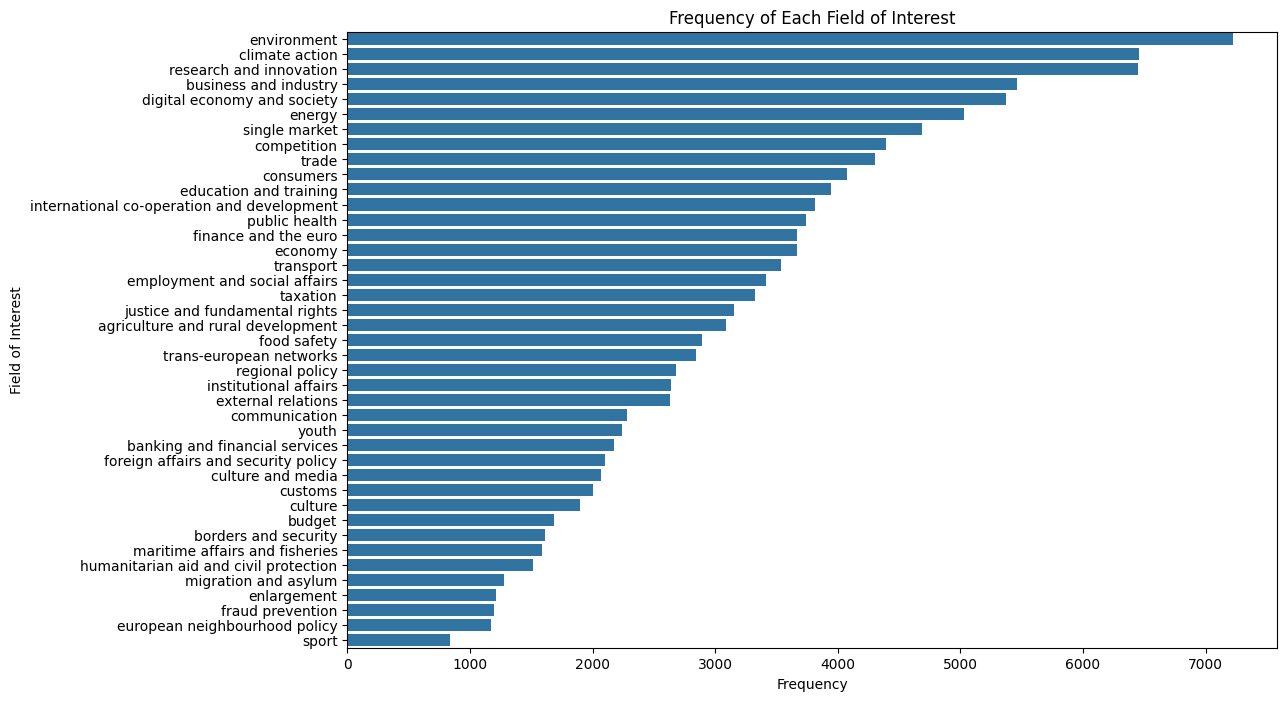

In [8]:
from collections import Counter
import seaborn as sns

# Split the 'Fields of interest' strings and normalize the entries
fields = df_tr["Fields of interest"].str.split(",").explode().str.strip().str.lower()

# Count the occurrences of each field
field_counts = Counter(fields)

# Convert the counts to a DataFrame for plotting
df_field_counts = pd.DataFrame(field_counts.items(), columns=["Field", "Count"])

# Plot the frequency of each field of interest
plt.figure(figsize=(12, 8))
sns.barplot(
    x="Count", y="Field", data=df_field_counts.sort_values(by="Count", ascending=False)
)
plt.xlabel("Frequency")
plt.ylabel("Field of Interest")
plt.title("Frequency of Each Field of Interest")
plt.show()

# Analisar os tipos de atores


In [9]:
cat_mapper = {
    "Non-governmental organisations, platforms and networks and similar": "NGOs",
    "Trade and business associations": "Business",
    "Companies & groups": "Business",
    "Other organisations, public or mixed entities": "Other",
    "Trade unions and professional associations": "Other",
    "Self-employed individuals": "Other",
    "Think tanks and research institutions": "Other",
    "Professional consultancies": "Other",
    "Academic institutions": "Other",
    "Associations and networks of public authorities": "Other",
    "Organisations representing churches and religious communities": "Other",
    "Law firms": "Other",
    "Entities, offices or networks established by third countries": "Other",
}

In [10]:
df_combined["month"] = df_combined["meeting_date"].apply(lambda x: "-".join(x.split("-")[:2]))
df_combined["cat_mapped"] = df_combined["Category of registration"].apply(
    lambda x: cat_mapper.get(x)
)

In [11]:
# df_combined[['month', 'Category of registration']]
df_g_n_meetings = (
    df_combined[["month"]]
    .join(pd.get_dummies(df_combined[["cat_mapped"]]))
    .groupby("month")
    .sum()
    .reset_index()
)

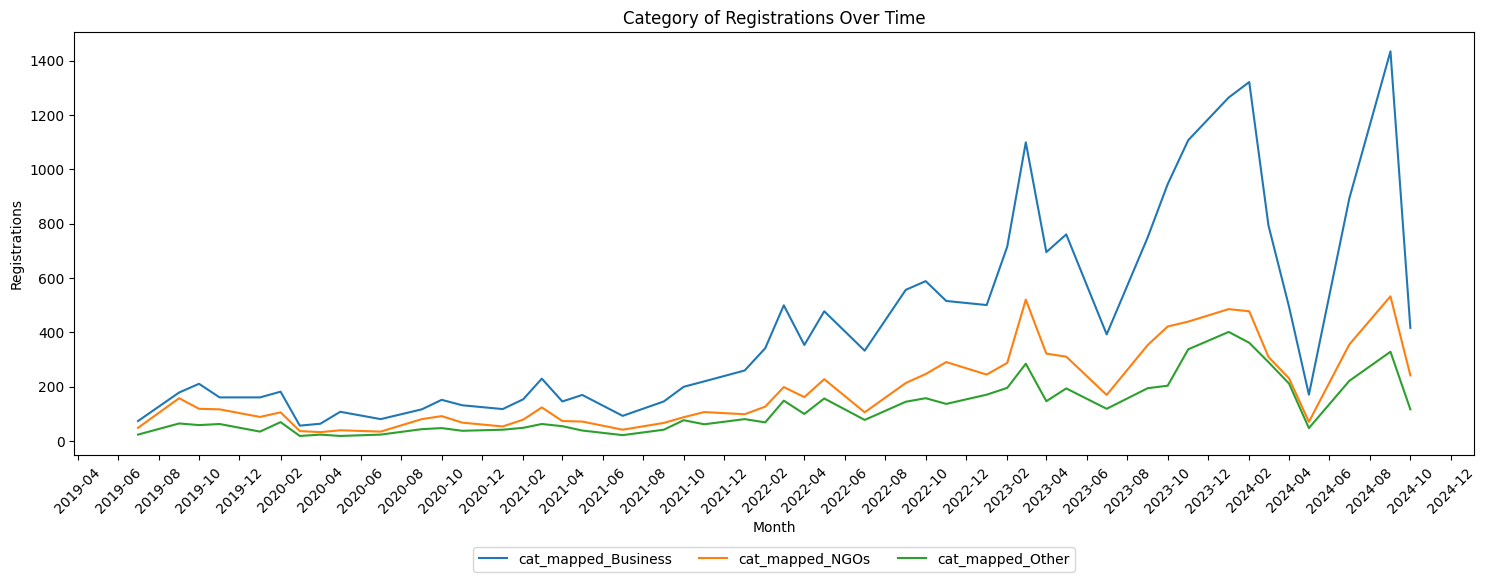

In [12]:
# Convert 'month' column to datetime
df = df_g_n_meetings.copy()
df["month"] = pd.to_datetime(df["month"])

# Set 'month' as the index for better plotting
df.set_index("month", inplace=True)

df = df[(df.index.month != 8) & (df.index.month != 12) & (df.index.month != 6)]
# Plot each column
plt.figure(figsize=(15, 6))
for column in df.columns:
    plt.plot(df.index, df[column], label=column)

# Add labels and title
plt.xlabel("Month")
plt.ylabel("Registrations")
plt.title("Category of Registrations Over Time")

plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=2))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))

# Set legend at the bottom
plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.2), ncol=3)
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()

In [13]:
df_meetings[["attendees", "title"]].groupby("attendees").count().sort_values(
    "title", ascending=False
).to_csv("teste.csv")

In [14]:
df_meetings[["member_id", "member_capacity", "title"]].groupby(
    ["member_id", "member_capacity"]
).count()

title
member_id member_capacity                     
101039.0  Rapporteur for opinion             1
          Shadow rapporteur                  9
          Shadow rapporteur for opinion      1
101585    Member                            25
101585.0  Member                           310
...                                        ...
99945     Member                            15
          Shadow rapporteur                  2
99945.0   Member                            12
          Rapporteur                         5
          Shadow rapporteur                 49

[2815 rows x 1 columns]

# Analisar reuniões por parlamentar

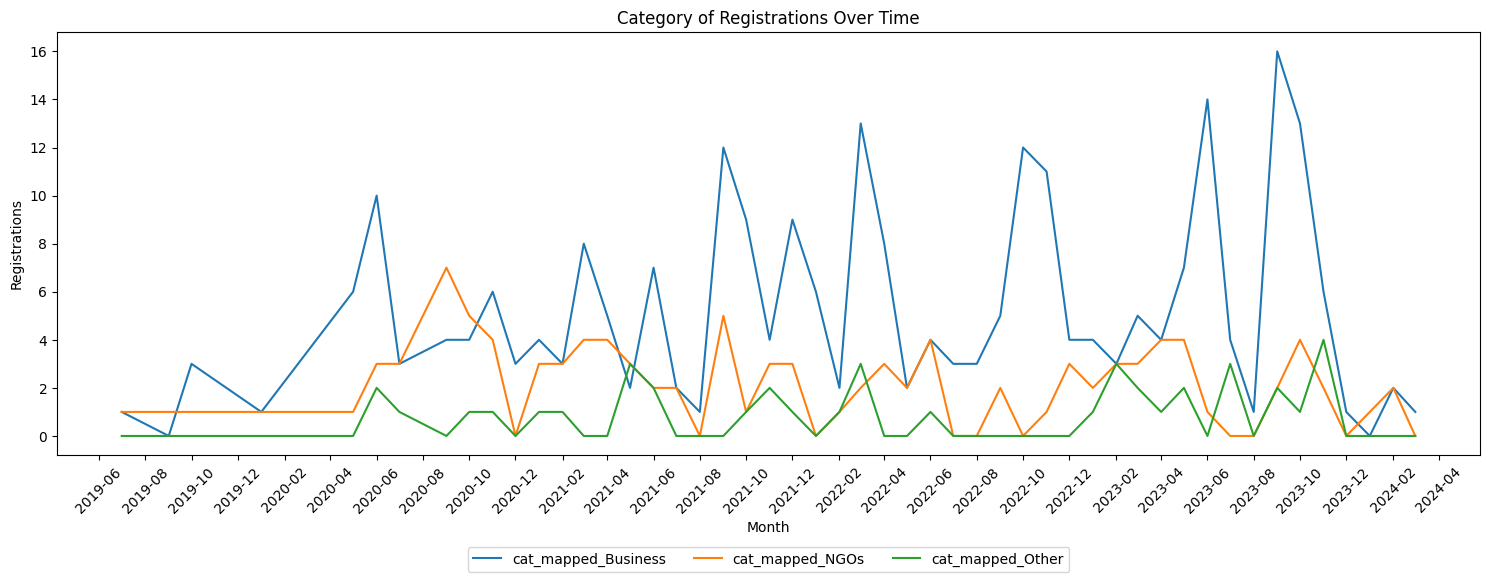

In [15]:
df_final = df_combined.pivot_table(index='member_id', columns="cat_mapped", aggfunc='size', fill_value=0)
df_final['Total'] = df_final.sum(axis=1)
df_final.sort_values('Total', ascending=False)


# Convert 'month' column to datetime
df = df_combined[df_combined['member_id'] == '96711.0' ].copy()
df = (
    df[["month"]]
    .join(pd.get_dummies(df[["cat_mapped"]]))
    .groupby("month")
    .sum()
    .reset_index()
)

df["month"] = pd.to_datetime(df["month"])

# Set 'month' as the index for better plotting
df.set_index("month", inplace=True)

# df = df[(df.index.month != 8) & (df.index.month != 12) & (df.index.month != 6)]
# Plot each column
plt.figure(figsize=(15, 6))
for column in df.columns:
    plt.plot(df.index, df[column], label=column)

# Add labels and title
plt.xlabel("Month")
plt.ylabel("Registrations")
plt.title("Category of Registrations Over Time")

plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=2))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))

# Set legend at the bottom
plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.2), ncol=3)
plt.xticks(rotation=45)
plt.tight_layout()

# Show the plot
plt.show()